In [2]:
#SIR_ODE
import numpy as np



def model(ini, time_step, params):
	Y = np.zeros(3) #column vector for the state variables
	X = ini
	mu = 0
	beta = params[0]
	gamma = params[1]


	Y[0] = mu - beta*X[0]*X[1] - mu*X[0] #S
	Y[1] = beta*X[0]*X[1] - gamma*X[1] - mu*X[1] #I
	Y[2] = gamma*X[1] - mu*X[2] #R

	return Y



def x0fcn(params, data):
	S0 = 1.0 - (data[0]/params[2])
	I0 = data[0]/params[2]
	R0 = 0.0
	X0 = [S0, I0, R0]
	return X0





def yfcn(res, params):
	return res[:,1]*params[2]

In [18]:
#sir_cost
from scipy.stats import poisson
from scipy.stats import norm

from scipy.integrate import odeint as ode

def NLL(params, data, times): #negative log likelihood
	params = np.abs(params)
	data = np.array(data)
	res = ode(model, x0fcn(params,data), times, args=(params,))
	y = yfcn(res, params)
	nll = sum(y) - sum(data*np.log(y))
	# note this is a slightly shortened version--there's an additive constant term missing but it 
	# makes calculation faster and won't alter the threshold. Alternatively, can do:
	# nll = -sum(np.log(poisson.pmf(np.round(data),np.round(y)))) # the round is b/c Poisson is for (integer) count data
	# this can also barf if data and y are too far apart because the dpois will be ~0, which makes the log angry
	
	# ML using normally distributed measurement error (least squares)
	# nll = -sum(np.log(norm.pdf(data,y,0.1*np.mean(data)))) # example WLS assuming sigma = 0.1*mean(data)
	# nll = sum((y - data)**2)  # alternatively can do OLS but note this will mess with the thresholds 
	#                             for the profile! This version of OLS is off by a scaling factor from
	#                             actual LL units.
	return nll

In [71]:
#PROFLIKE
# Input definitions
# params = starting parameters (all, including the one to be profiled)
# profparam = index within params for the parameter to be profiled
#   ---reminder to make this allow you to pass the name instead later on
# costfun = cost function for the model - should include params, times, and data as arguments.
#   Note costfun doesn't need to be specially set up for fixing the profiled parameter, 
#   it's just the regular function you would use to estimate all the parameters
#   (it will get reworked to fix one of them inside ProfLike)
# times, data = data set (times & values, or whatever makes sense)
#   ---possibly change this so it's included in costfun and not a separate set of inputs? Hmm.
# perrange = the percent/fraction range to profile the parameter over (default is 0.5)
# numpoints = number of points to profile at in each direction (default is 10)

# Output
# A list with:
#   - profparvals: the values of the profiled parameter that were used
#   - fnvals: the cost function value at each profiled parameter value
#   - convergence: the convergence value at each profiled parameter value
#   - paramestvals: the estimates of the other parameters at each profiled parameter value

import numpy as np
import scipy.optimize as optimize
import copy

#import sir_ode
#import sir_cost

def proflike (params, profindex, cost_func, times, data, perrange = 0.5, numpoints = 10):
	profrangedown = np.linspace(params[profindex], params[profindex] * (1 - perrange), numpoints).tolist()
	profrangeup = np.linspace(params[profindex], params[profindex] * (1 + perrange), numpoints).tolist()[1:] #skip the duplicated values
	profrange = [profrangedown, profrangeup]
	currvals = []
	currparams = []
	currflags = []

	def profcost (fit_params, profparam, profindex, data, times, cost_func):
		paramstest = fit_params.tolist()
		paramstest.insert(profindex, profparam)
		return cost_func (paramstest, data, times)

	fit_params = params.tolist() #make a copy of params so we won't change the origianl list
	fit_params.pop(profindex)
	print ('Starting profile...')
	for i in range(len(profrange)):
		for j in profrange[i]:
			print (i, j)
			optimizer = optimize.minimize(profcost, fit_params, args=(j, profindex, data, times, cost_func), method='Nelder-Mead')
			fit_params = np.abs(optimizer.x).tolist() #save current fitted params as starting values for next round
			#print optimizer.fun
			currvals.append(optimizer.fun)
			currflags.append(optimizer.success)
			currparams.append(np.abs(optimizer.x).tolist())

	#structure the return output
	print(profrangedown)
	profrangedown.reverse()
	print(profrangedown.reverse())
	out_profparam = profrangedown+profrangeup
	temp_ind = (len(profrangedown))
	print(temp_ind)
	#temp_ind.reverse()
	out_params = [currparams[i] for i in range(temp_ind)]+currparams[len(profrangedown):]
	out_fvals = [currvals[i] for i in range(temp_ind)]+currvals[len(profrangedown):]
	out_flags = [currflags[i] for i in range(temp_ind)]+currflags[len(profrangedown):]
	output = {'profparam': out_profparam, 'fitparam': np.array(out_params), 'fcnvals': out_fvals, 'convergence': out_flags}
	return output



In [72]:
#minifim
from scipy.integrate import odeint as ode

def minifisher (times, params, data, delta = 0.001):
	#params = np.array(params)
	listX = []
	params_1 = np.array (params)
	params_2 = np.array (params)
	for i in range(len(params)):
		params_1[i] = params[i] * (1+delta)
		params_2[i]= params[i] * (1-delta)

		res_1 = ode(model, x0fcn(params_1,data), times, args=(params_1,))
		res_2 = ode(model, x0fcn(params_2,data), times, args=(params_2,))
		subX = (yfcn(res_1, params_1) - yfcn(res_2, params_2)) / (2 * delta * params[i])
		listX.append(subX.tolist())
	X = np.matrix(listX)
	FIM = np.dot(X, X.transpose())
	return FIM

[0.9987875, 0.0012125, 0.0]
[[9.98787500e-01 1.21250000e-03 0.00000000e+00]
 [9.92834121e-01 3.42935111e-03 3.73652746e-03]
 [9.76425512e-01 9.42223912e-03 1.41522490e-02]
 [9.34348113e-01 2.39687527e-02 4.16831342e-02]
 [8.43538255e-01 5.08762600e-02 1.05585485e-01]
 [7.02321239e-01 7.75843282e-02 2.20094432e-01]
 [5.60356082e-01 7.84128832e-02 3.61231035e-01]
 [4.62754877e-01 5.64047466e-02 4.80840377e-01]
 [4.08915764e-01 3.29386418e-02 5.58145594e-01]
 [3.81909932e-01 1.72417257e-02 6.00848342e-01]
 [3.68845789e-01 8.55202325e-03 6.22602187e-01]
 [3.62613413e-01 4.13356186e-03 6.33253025e-01]
 [3.59657103e-01 1.97349811e-03 6.38369398e-01]
 [3.58258259e-01 9.36738200e-04 6.40805003e-01]
 [3.57597107e-01 4.43409290e-04 6.41959484e-01]]
[  97.          274.34808883  753.77912973 1917.50021899 4070.10080347
 6206.74625843 6273.03065253 4512.37972884 2635.09134782 1379.33805897
  684.1618596   330.68494879  157.87984873   74.93905598   35.47274323]


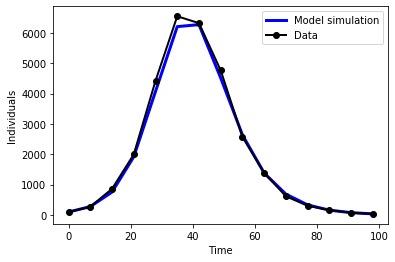

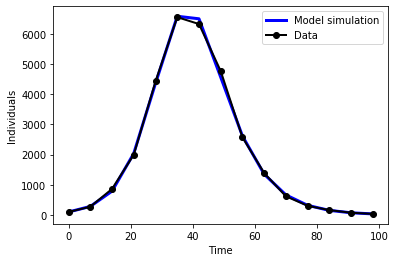

3
[[1.98066299e+10 1.10016690e+10 3.77053476e+04]
 [1.10016690e+10 1.10680375e+10 2.59296580e+04]
 [3.77053476e+04 2.59296580e+04 7.68473201e-02]]
Starting profile...
0 0.3998601220411401
0 0.38875289642888616
0 0.3776456708166323
0 0.3665384452043784
0 0.3554312195921245
0 0.3443239939798706
0 0.3332167683676167
0 0.32210954275536285
0 0.31100231714310894
0 0.29989509153085503
1 0.410967347653394
1 0.42207457326564785
1 0.43318179887790176
1 0.44428902449015567
1 0.4553962501024095
1 0.46650347571466344
1 0.4776107013269173
1 0.4887179269391712
1 0.4998251525514251
[0.3998601220411401, 0.38875289642888616, 0.3776456708166323, 0.3665384452043784, 0.3554312195921245, 0.3443239939798706, 0.3332167683676167, 0.32210954275536285, 0.31100231714310894, 0.29989509153085503]
None
10
['gamma', 'k']
[0.2467700281939366, 80256.57055016875]
Starting profile...
0 0.2467700281939366
0 0.23991530518854948
0 0.23306058218316233
0 0.22620585917777522
0 0.21935113617238808
0 0.21249641316700096
0 0.2056

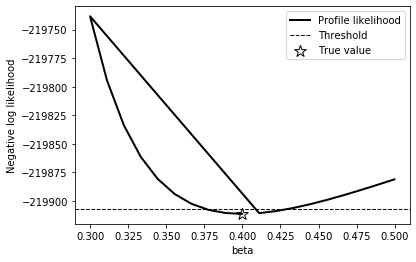

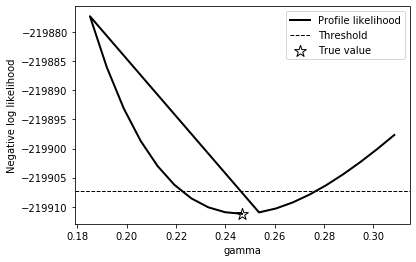

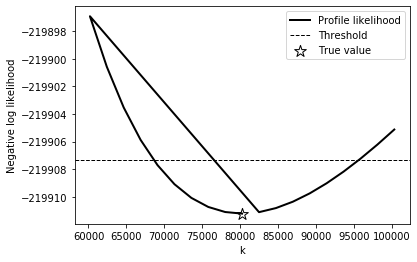

In [73]:

#### Import all the packages ####
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
#import sir_ode
#import sir_cost
#import minifim
#import proflike

from scipy.integrate import odeint as ode




#### Load Data ####
times = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98]
data = [97, 271, 860, 1995, 4419, 6549, 6321, 4763, 2571, 1385, 615, 302, 159, 72, 34]

#shortened version for seeing how truncated data affects the estimation
#times = times[0:7]
#data = data[0:7]

#### Set initial parameter values and initial states ####
params = [0.4, 0.25, 80000.0]#make sure all the params and inition states are float
paramnames = ['beta', 'gamma', 'k']
ini = x0fcn(params,data)
print (ini)

#### Simulate and plot the model ####
res = ode(model, ini, times, args=(params,))
print (res)
sim_measure = yfcn(res, params)
print (sim_measure)
plt.plot(times, sim_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()


#### Parameter estimation ####
optimizer = optimize.minimize(NLL, params, args=(data, times), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = x0fcn(paramests, data)

#### Re-simulate and plot the model with the final parameter estimates ####
xest = ode(model, iniests, times, args=(paramests,))
est_measure = yfcn(xest, paramests)
plt.plot(times, est_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()

#### Calculate the simplified Fisher Information Matrix (FIM) ####
FIM = minifisher(times, params, data, delta = 0.001)
print (np.linalg.matrix_rank(FIM)) #calculate rank of FIM
print (FIM)

#### Generate profile likelihoods and confidence bounds ####
threshold = stats.chi2.ppf(0.95,len(paramests))/2.0 + optimizer.fun
perrange = 0.25 #percent range for profile to run across

profiles={}
for i in range(len(paramests)):
	profiles[paramnames[i]] = proflike(paramests, i, NLL, times, data, perrange=perrange)
	plt.figure()
	plt.scatter(paramests[i], optimizer.fun, marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	plt.plot(profiles[paramnames[i]]['profparam'], profiles[paramnames[i]]['fcnvals'], 'k-', linewidth=2, label='Profile likelihood')
	plt.axhline(y=threshold, ls='--',linewidth=1.0, label='Threshold', color='k')
	plt.xlabel(paramnames[i])
	plt.ylabel('Negative log likelihood')
	plt.legend(scatterpoints = 1)
	paramnames_fit = [ n for n in paramnames if n not in [paramnames[i]]]
	paramests_fit = [v for v in paramests if v not in [paramests[i]]]
	print (paramnames_fit)
	print (paramests_fit)

	#plot parameter relationships
	#for j in range(profiles[paramnames[i]]['fitparam'].shape[1]):
	#	plt.figure()
	#	plt.plot(profiles[paramnames[i]]['profparam'],profiles[paramnames[i]]['fitparam'][:,j],'k-', linewidth=2, label=paramnames_fit[j])
	#	plt.scatter(paramests[i], paramests_fit[j], marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	#	plt.xlabel(paramnames[i])
	#	plt.ylabel(paramnames_fit[j])
	#	plt.legend(scatterpoints = 1)
print (profiles)
plt.show()